# Preparativos

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
from collections import Counter

Hay que copiar las imágenes en el drive para poder trabajar con ellas. Link de descarga: [carpetas de descarga](https://drive.google.com/drive/folders/1xjw57WDE9Bp-XVPEkesbATxW_XgJxjcQ)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Entrenamiento

In [ ]:
path = '/content/drive/MyDrive/Aux/'
# Listas de paths de imagenes
monos = [path+"monos/"+file for file in os.listdir(path+"monos/")]
aerea = [path+"aerea/"+file for file in os.listdir(path+"aerea/")]
comida = [path+"Comida/"+file for file in os.listdir(path+"Comida/")]

In [ ]:
#monos_train, monos_test  = monos[:-1], monos[-1]
#aerea_train, aerea_test = aerea[:-1], aerea[-1]
comida_train = [x for x in comida if "Entrenamiento" in x]
comida_test = [x for x in comida if "Prueba" in x]

In [ ]:
# Este es random, no nos conviene tanto
# generamos los conjuntos de entrenamiento y de prueba
# monos_test, monos_train = train_test_split(monos, test_size=0.2)
# aerea_test, aerea_train = train_test_split(aerea, test_size=0.2)
# comida_test, comida_train = train_test_split(comida, test_size=0.2)

## 1 Preprocesamiento

*Realizar preprocesamiento de sus imágenes con un filtro gaussiano*

Debemos aplicar un filtro **Gaussiano** a la imágen para que los colores se estandaricen y no existan tantos detalles

### Con PIL

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

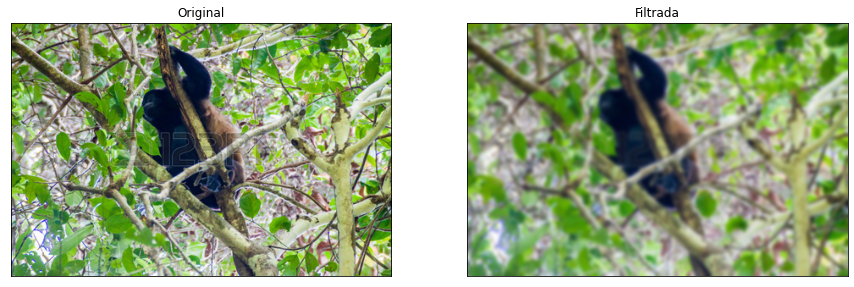

In [ ]:
from PIL import Image, ImageFilter
  
image = Image.open(monos[0])
  
# se aplica un filtro gaussiano predefinido
blur = image.filter(ImageFilter.GaussianBlur)
# mostrando la imágen
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(image),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Filtrada')
plt.xticks([]), plt.yticks([])

# https://www.geeksforgeeks.org/apply-a-gauss-filter-to-an-image-with-python/

### Con OpenCV

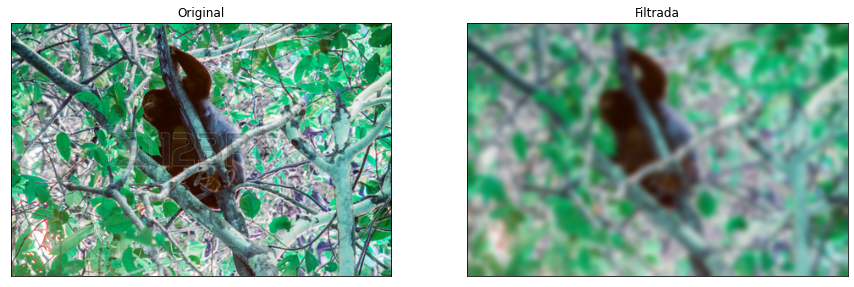

In [ ]:
import cv2

img = cv2.imread(monos[0])

blur = cv2.GaussianBlur(img,(21,21),0)

plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Filtrada')
plt.xticks([]), plt.yticks([])
plt.show()


#https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

### Aplicación al dataset
Ocupamos OpenCV por que las demás partes ocupan OpenCV para la modificación de la imágen

In [ ]:
def aplicar_filtro(img, intensidad_x, intensidad_y=None):
  '''Aplica cierta intensidad de filtro gaussiano
  
  return imagen con el filtro gaussiano aplicado
  '''
  if intensidad_y==None: intensidad_y = intensidad_x
  if intensidad_x%2!=1: intensidad_x += 1
  if intensidad_y%2!=1: intensidad_y += 1

  post = cv2.GaussianBlur(img,(intensidad_x,intensidad_y),0)
  return post

def generar_dataset_blur(urls, intensidad_x, intensidad_y=None):
  '''Genera una lista de imagenes a las que se les aplico el filtro
  gaussiano
  
  return lista imágenes filtradas
  '''

  imagenes_filtradas = [ aplicar_filtro(cv2.imread(url), intensidad_x, intensidad_y) 
                        for url in urls]
                        
  return imagenes_filtradas

In [ ]:
#monos_blur_train = generar_dataset_blur(monos_train, 21)
comida_blur_train = generar_dataset_blur(comida_train, 21)
#aerea_blur_train = generar_dataset_blur(aerea_train, 21)

In [ ]:
cv2_imshow(comida_blur_train[1])

In [ ]:
import matplotlib.image as pltim 

for i in range(len(comida_blur_train)):
  print(comida_train[i])
  imagen = cv2.cvtColor(comida_blur_train[i], cv2.COLOR_BGR2RGB)
  pltim.imsave("/content/drive/MyDrive/Aux/ComidaBlur/"
          +comida_train[i].split("/")[-1],imagen)
  plt.imshow(imagen)
  plt.show()

## 2 Selección de imágenes

*Seleccionar sus imágenes con zonas aledañas a clasificar, verifique que tenga regiones contiguas.*

Seleccionamos las imágenes que deben tener regiones contiguas. En este momento el dataset ya tiene imágenes con zonas contiguas

## 3 Generar máscaras por clase

*Genere sus propias máscaras de análisis para que sólo se quede con información de cada zona.*

Generaremos las mascaras para identificar las clases en nuestro dataset

### Por K-Means

Aplicamos K-Means para segmentar imágenes en colores y posteriormente aplicar una máscara, seleccionando las diferentes clases en la imagen. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image, ImageFilter

In [ ]:
def segmentar(img, n=5):
  I1 = np.asarray(img,dtype=np.float32)/255

  # Extraemos cada canal por separado
  R = I1[:,:,0]
  G = I1[:,:,1]
  B = I1[:,:,2]

  # Aplanamos los canales, para que sean vectores en vez de 
  # matrices
  XR = R.reshape((-1, 1))  
  XG = G.reshape((-1, 1)) 
  XB = B.reshape((-1, 1)) 

  # concatenamos los vectores para generar una matriz de 
  # (width*height,3) 
  X = np.concatenate((XR,XG,XB),axis=1)

  # aplicamos el algoritmo de kmeans con n grupos (colores)
  n = 5
  k_means = KMeans(n_clusters=n)
  k_means.fit(X)

  # Obtenemos los centros de los grupos, y las etiquetas de estos
  # las etiquetas nos indican a que indice de grupos (definidos por
  # los centroides) pertenece cada pixel
  centroides = k_means.cluster_centers_
  etiquetas = k_means.labels_

  # Creamos un nuevo arreglo indicando el nuevo valor para cada pixel
  # en cada una de sus 3 componentes
  m = XR.shape
  for i in range(m[0]):
      XR[i] = centroides[etiquetas[i]][0] 
      XG[i] = centroides[etiquetas[i]][1] 
      XB[i] = centroides[etiquetas[i]][2] 
  # redimensionamos para que sean matrices
  XR.shape = R.shape 
  XG.shape = G.shape
  XB.shape = B.shape 
  # 
  XR = XR[:, :, np.newaxis]  
  XG = XG[:, :, np.newaxis]
  XB = XB[:, :, np.newaxis]

  # concatenamos las componentes rgb
  Y = np.concatenate((XR,XG,XB),axis=2)

  # imprimos la imágen original y la segmentada
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])
  plt.show()
  plt.imshow(Y)
  plt.xticks([]), plt.yticks([])
  plt.show()

  return Y, centroides

In [ ]:
def segment_by_color(img_bgr, r_a, r_b):
    #
    # TODO:
    # - Change color space from RGB to HSV.
    #   Check online documentation for cv2.cvtColor function
    # - Determine the pixels whose color is in the color range of the ball.
    #   Check online documentation for cv2.inRange
    # - Calculate the centroid of all pixels in the given color range (ball position).
    #   Check online documentation for cv2.findNonZero and cv2.mean
    # - Calculate the centroid of the segmented region in the cartesian space
    #   using the point cloud 'points'. Use numpy array notation to process the point cloud data.
    #   Example: 'points[240,320][1]' gets the 'y' value of the point corresponding to
    #   the pixel in the center of the image.
    # Return a tuple of the form [img_c, img_r, x, y, z] where:
    # [img_c, img_r] is the centroid of the segmented region in image coordinates.
    # [x,y,z] is the centroid of the segmented region in cartesian coordinate. 
    #

    img_bin = cv2.inRange(img_bgr, r_a, r_b)
    plt.imshow(img_bin)
    plt.xticks([]), plt.yticks([])
    plt.show()
    #plt.imshow(cv2.cvtColor(img_bin, cv2.COLOR_BGR2RGB))
    #img_bin = cv2.inRange(img_bgr, r_a, r_b)
    #cv2_imshow(img_bin)

    #indices = cv2.findNonZero(img_bin)
    #[img_x, img_y, a, b] = cv2.mean(indices)
    #print([img_x, img_y])

    '''
    counter = 0
    x = 0
    y = 0
    z = 0
    for [[c,r]] in indices:
        xt = points[r,c][0]
        yt = points[r,c][1]
        zt = points[r,c][2]
        if math.isnan(xt) or math.isnan(yt) or math.isnan(zt):
            continue
        [x,y,z, counter] = [x + xt, y + yt, z + zt, counter+1]
        x = x/counter if counter > 0 else 0
        y = y/counter if counter > 0 else 0
        z = z/counter if counter > 0 else 0'''
        
    return img_bin

In [ ]:
def mostrar_grupos(img, colores, keys):
  dic_colores = {k:list() for k in keys}
  dic_masks = {k:list() for k in keys}
  
  for color in colores:
    mask = segment_by_color(img, color, color)
    clase = input("key: ")
    dic_colores[clase].append(color)
    dic_masks[clase].append(mask)

  return dic_colores, dic_masks

In [ ]:
def generar_mascaras(keys, dataset):
  
  diccionarios_keys = list()
  diccionarios_masks = list()
  agrupadas = list()

  for i in range(len(dataset)):
    # Se aplica Kmeans
    Y, centroides = segmentar(cv2.cvtColor(dataset[i], cv2.COLOR_BGR2RGB))
    agrupadas.append(Y)

    # Se generan las máscaras
    conjuntos, masks = mostrar_grupos(Y, centroides, keys)
    diccionarios_keys.append(conjuntos)
    diccionarios_masks.append(masks)

  # Se juntan los diccionarios
  full_dict_ranges = {k:list() for k in keys}
  for dic in diccionarios_keys:
    for key in dic.keys():
      full_dict_ranges[key].extend(dic[key])
  
  # Se juntan las mascaras que sean de la misma clase de la
  # misma imágen
  for dict_clases in diccionarios_masks:
    for key in dict_clases:
      if len(dict_clases[key]) > 1:
        new_mask = np.zeros(dict_clases[key][0].shape)
        for array in dict_clases[key]:
          new_mask += array
        dict_clases[key] = new_mask
      else:
        dict_clases[key] = dict_clases[key][0]

  rangos = {k:None for k in keys}
  for key in full_dict_ranges.keys():
    Aux = np.array(full_dict_ranges[key])
    rangos[key] = [np.min(Aux,axis=0),np.max(Aux,axis=0)]

  return diccionarios_masks, rangos, agrupadas

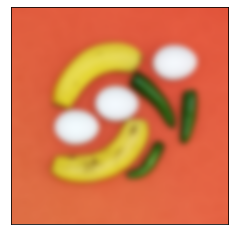

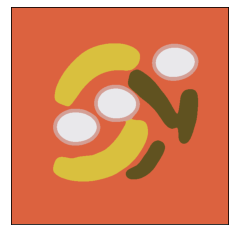

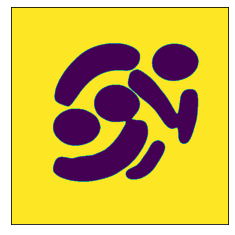

key: fondo


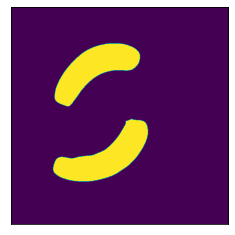

key: platano


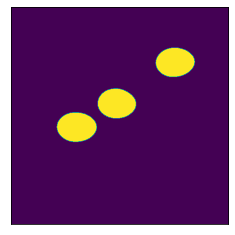

key: huevo


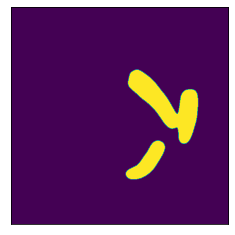

key: chile


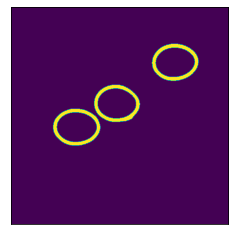

key: huevo


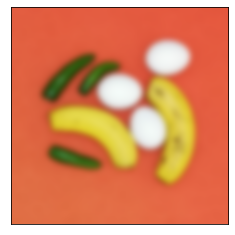

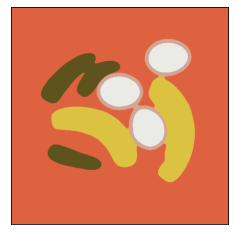

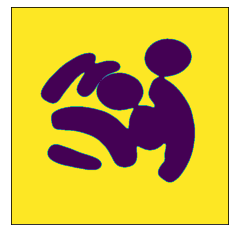

key: fondo


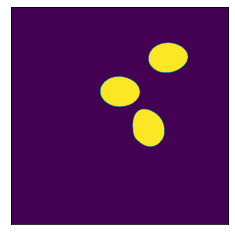

key: huevo


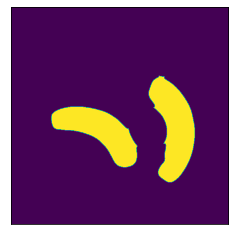

key: platano


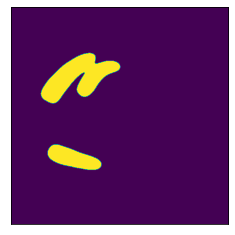

key: chile


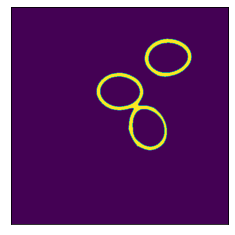

key: huevo


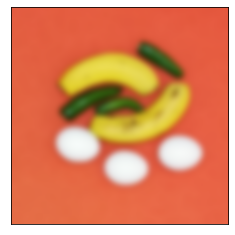

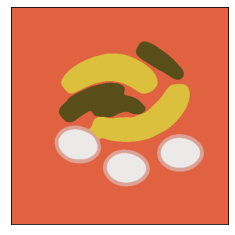

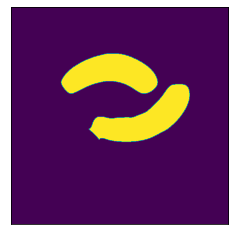

key: platano


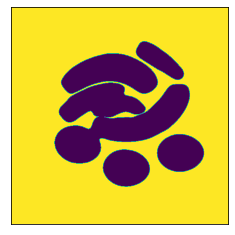

key: fondo


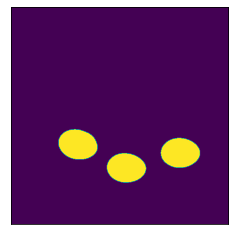

key: huevo


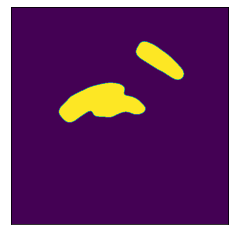

key: chile


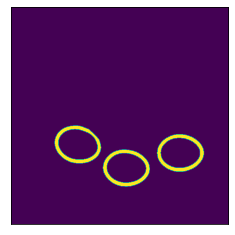

key: huevo


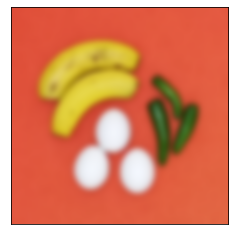

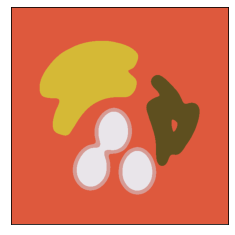

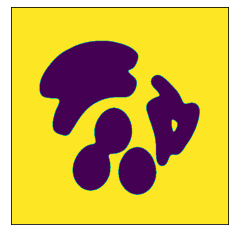

key: fondo


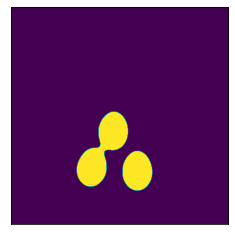

key: huevo


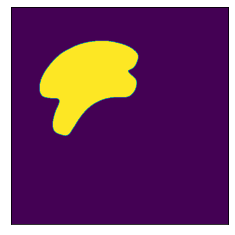

key: platano


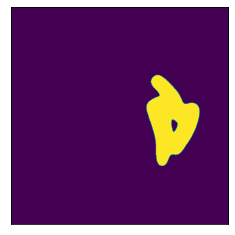

key: chile


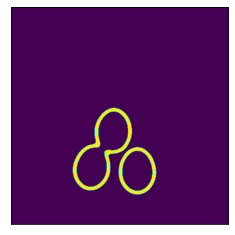

key: huevo


In [ ]:
keys = ["huevo", "fondo", "platano", "chile"]
diccionarios_masks, rangos, agrupadas = generar_mascaras(keys, comida_blur_train)

/content/drive/MyDrive/Aux/Comida/Entrenamiento2.jpg
(600, 600, 3)


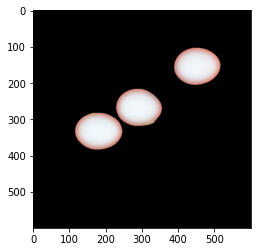

(600, 600, 3)


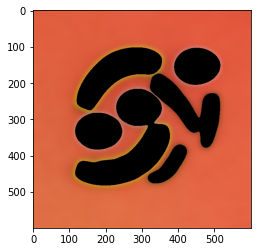

(600, 600, 3)


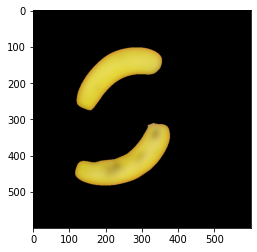

(600, 600, 3)


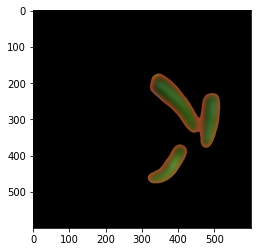

/content/drive/MyDrive/Aux/Comida/Entrenamiento3.jpg
(600, 600, 3)


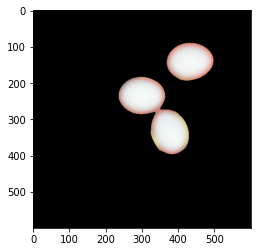

(600, 600, 3)


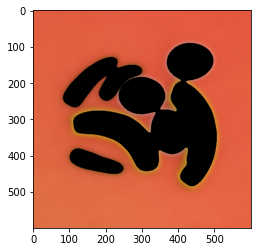

(600, 600, 3)


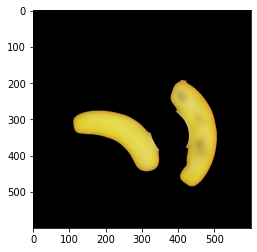

(600, 600, 3)


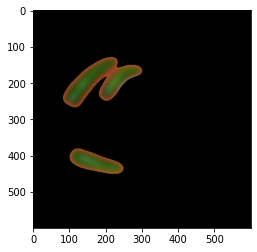

/content/drive/MyDrive/Aux/Comida/Entrenamiento4.jpg
(600, 600, 3)


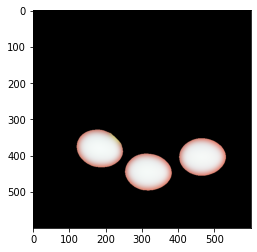

(600, 600, 3)


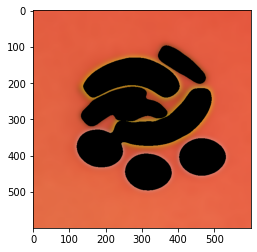

(600, 600, 3)


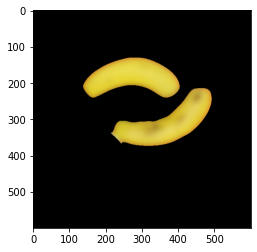

(600, 600, 3)


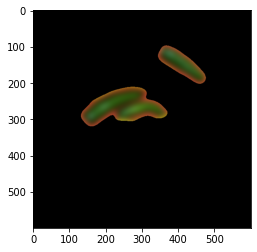

/content/drive/MyDrive/Aux/Comida/Entrenamiento1.jpg
(600, 600, 3)


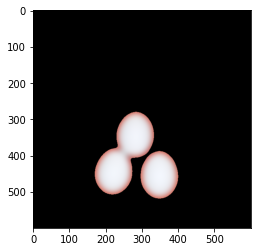

(600, 600, 3)


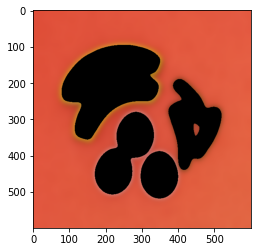

(600, 600, 3)


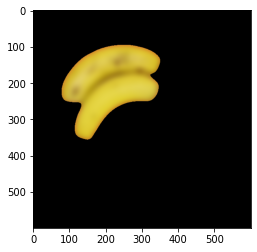

(600, 600, 3)


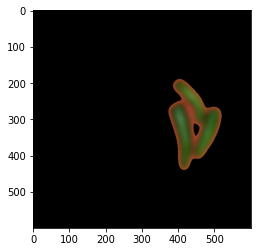

In [ ]:
import matplotlib.image as pltim 

for i in range(len(comida_blur_train)):
  print(comida_train[i])
  for key in keys:
    mascara1 = diccionarios_masks[i][key]
    imagen = cv2.cvtColor(comida_blur_train[i], cv2.COLOR_BGR2RGB)
    #print(imagen.shape)
    mascara1.shape = (600,600,1)
    #print(mascara1.shape)
    mascara1 = mascara1//255
    res = imagen*mascara1
    res = res.astype('uint8')
    print(res.shape)
    pltim.imsave("/content/drive/MyDrive/Aux/ComidaMascara/"
            +comida_train[i].split("/")[-1][:-4]+"_"+key+".jpg",
            res)
    plt.imshow(res)
    plt.show()

### A mano

Segmentamos con la siguiente herramienta

## 4 Generar Clasificador
*Implementar un clasificador bayesiano, obteniendo información a priori de las imágenes para las diferentes regiones de imagen.*

In [ ]:
def aplicar_filtro(img, intensidad_x, intensidad_y=None):
  '''Aplica cierta intensidad de filtro gaussiano
  
  return imagen con el filtro gaussiano aplicado
  '''
  if intensidad_y==None: intensidad_y = intensidad_x
  if intensidad_x%2!=1: intensidad_x += 1
  if intensidad_y%2!=1: intensidad_y += 1

  post = cv2.GaussianBlur(img,(intensidad_x,intensidad_y),0)
  return post

In [ ]:
class Bayes():
  def __init__(self,dict_urls,clases):

    self.clases = list(clases) 
    self.dict_urls = dict_urls 

    self.imagenes = self.cargar_imagenes()
    print()
    self.prob_priori = self.calc_probs_priori()
    print()
    self.med_clases = self.calc_medias()
    print()
    self.cov_clases = self.calc_cov()
    print()
    self.dic_determinantes, self.dic_inversas = self.calc_inversa_det()

  def cargar_imagenes(self):
    '''Lee las imagenes y als guarda en un diccionario por clase
    
    return diccionario de imagenes por clase
    '''
    print("=============================================")
    print("             CARGANDO IMAGENES")
    print("=============================================")

    # se crea un diccionario nuevo con las clases indicadas
    dict_imagenes = {k:list() for k in self.clases}
    # para cada clase
    for clase in self.clases:
      # para cada imagen indicada 
      for url in self.dict_urls[clase]:
        # se lee la imágen, se trasforma a RGB y se agrega a la lista de 
        # imagenes de la case
        img = cv2.imread(url)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dict_imagenes[clase].append(img)
      print("\tImagenes leidas para la clase "+clase+":",len(dict_imagenes[clase]))

    print("\n\tImagenes leídas en total:",sum([len(dict_imagenes[x]) for x in self.clases]))
    return dict_imagenes

  def calc_probs_priori(self):
    '''Calcula las probabilidades a priori de als clases'''

    print("=============================================")
    print("     CALCULANDO PROBABILIADES A PRIORI")
    print("=============================================")

    # Diccionario para guardar las probabilidades por clase
    dic_probs = dict()

    # por cada clase
    for clase in self.clases:

      # Creamos contadores para determinar el número de pixeles total de todas
      # las imagenes y la cantidad de pixeles que pertenecen a la clase
      # de todas las imagenes
      cant_pixeles_clase = 0
      cant_pixeles_total = 0

      # para cada imágen de la clase
      for imagen in self.imagenes[clase]:
        # Sumamos en el eje 3, así sumamos la componente RGB de cada pixel
        suma_rgb = np.sum(imagen,axis=2)
        # Filtramos, solo contamos los pixeles cuya suma RGB sea mayor a 0
        cantidad = np.sum(suma_rgb != 0)
        # agregamos las cantidades de número de pixeles de la clase y 
        # numero de pixeles totales
        cant_pixeles_clase += cantidad
        cant_pixeles_total += imagen.shape[0]*imagen.shape[1]

      # Calculamos la probabilidad de la clase con respecto a todos los pixeles
      # de todas las imágenes
      dic_probs[clase] = cant_pixeles_clase/cant_pixeles_total
      print("\n\tProbabilidad a priori clase "+clase+":",cant_pixeles_clase/cant_pixeles_total)
      print("\tPixeles de la clase en todas las imagenes:",cant_pixeles_clase)
      print("\tPixeles totales en las imágenes:",cant_pixeles_total)

    print("\n\tResumen probabilidades:")
    print("\t","clase","\t\t","probabilidad",sep="")
    for k,v in dic_probs.items():
      print("\t",k,"\t\t",round(v*100,4),"%",sep="")

    return dic_probs
  
  def cal_media_imagen(self, array):
    '''Genera la suma y cuenta los pixeles diferentes a negro de una 
    imagen
    
    Parámetros
    array: imagen RGB
    
    return suma de todos los pixeles en sus componentes RGB y cantida de
    pixeles diferentes al negro'''

    # Se suma en el eje 0 y 1 para tener un vector que represente la suma de 
    # todos los R, todos los G y todos los B
    suma = np.sum(array,axis=(0,1))
    # Se suma en el eje 2, para tener sumas R+G+B y contar cuantos son
    # diferentes a 0 (negro)
    suma_rgb = np.sum(array,axis=2)
    cantidad = np.sum(suma_rgb != 0)

    return suma, cantidad

  def cal_media_clase(self, lista_imagenes):
    '''Calcula la media por clase
    
    Parámetro
    lista_imagenes: Una lista de imágenes que pertenecen a una clase K
    
    return media de la lista de imágenes'''
  
    # Se genera un vector de 3 espacios
    media = np.zeros(3)
    cantidad_pixeles = 0
    
    # para cada imágen
    for imagen in lista_imagenes:
      # se calcula la suma de RGB para la imágen y la cantidad de pixeles
      # de la clase
      media_aux, cant_aux = self.cal_media_imagen(imagen)
      media += media_aux
      cantidad_pixeles += cant_aux

    print("\t\tCantidad de pixeles pertenecientes a la clase:",cantidad_pixeles)
    print("\t\tSuma de R's, G's y B's de todas las imágenes:\n\t\t",media)
    print("\t\tMedia de la clase:\n\t\t",media/cantidad_pixeles)
    return media/cantidad_pixeles

  def calc_medias(self):
    '''Calcula la media de todas las clase
    
    return diccionario de medias por clase'''
    print("=============================================")
    print("     CALCULANDO MEDIA DE LAS CLASES")
    print("=============================================")

    # diccionario nuevo
    dict_media = dict()

    # para cada clase
    for clase in self.clases:
      print("\n\tMedia de la clase "+clase)
      dict_media[clase] = self.cal_media_clase(self.imagenes[clase])

    return dict_media


  def covarianza_imagen(self, imagen, media_p):
    '''Determina la matriz de covarianza de una imágen
    
    Parámetros
    imagen: imagen de la que se calculará la covarianza
    media_p: media de la clase a la que pertenece la imagen

    return matriz de covarianza acumulada y el número de pixeles que se
    pertenecen a la clase en la imágen
    '''

    # cambia la forma de la media para que salga una matriz
    media = media_p.reshape((-1,1))
    # inicializamos variables auxiliares
    w,h,p = imagen.shape 
    cov = np.zeros((3,3))

    # para cada fila y columna
    for i in range(h):
      for j in range(w):
        # si el pixel no es negro
        if np.sum(imagen[i,j,:]) != 0:
          # se redimensiona el pixel
          pixel = imagen[i,j,:].reshape((-1,1))
          # se suma el valor del pixel menos la media por la transpuesta de la 
          # misma resta
          cov = cov + (pixel - media)@(pixel - media).T

    # Se determina la cantidad de pixeles diferentes de negro
    suma_rgb = np.sum(imagen,axis=2)
    cantidad = np.sum(suma_rgb != 0)

    return cov, cantidad

  def covarianza_clase(self, lista_imagenes, media):
    '''Calcula la matriz de covarianza para una clase
    
    Parametros
    lista_imagenes: Lista de imágenes que pertenecen a las clase
    
    return covarianza de la case'''
    
    # Inicia la covarianza de la clase como una matriz de 3x3
    cov_clase = np.zeros((3,3))
    # Inicializa la cantidad de pixeles que pertenecen a la clase
    cantidad_clase = 0
    # Transforma todas la imagenes para que sean tratadas como flotantes
    imagenes_float = [img.astype("float64") for img in lista_imagenes]

    # para cada imágen con números flotantes
    for imagen in imagenes_float:
      # se calcula la covarianza de la imágen y se calcula la cantidad de 
      # pixeles que representan a la clase en la imágen
      cov_aux, cant_aux = self.covarianza_imagen(imagen, media)
      # Se suman los valores de la covarianza y el de la cantidad de pixeles
      cov_clase += cov_aux 
      cantidad_clase += cant_aux

    # Se determina la matriz de covarianza dividiendo toda la suma entre la
    # cantidad de pixeles
    cov_clase_final = cov_clase/cantidad_clase
    print("\t\tMatriz acumulada de covarianzas:\n",cov_clase)
    print("\t\tCantidad de pixeles pertenecientes a la clase:",cantidad_clase)
    print("\t\tCovarianza de la clase:\n",cov_clase_final)
    return cov_clase_final

  def calc_cov(self):
    ''' Proxy para calcular las covarianzas
    
    return diccionario de covarianzas'''
    print("=============================================")
    print("    CALCULANDO COVARIANZA DE LAS CLASES")
    print("=============================================")
    # Diccionario nuevo
    dict_cov = dict()

    # para cada clase, se calcula la covarianza y la media, se agregan a los 
    # diccionarios
    for clase in self.clases:
      print("\n\tCovarianza de la clase "+clase)
      dict_cov[clase] = self.covarianza_clase(self.imagenes[clase],
                                              self.med_clases[clase])

    return dict_cov 

  def calc_inversa_det(self):
    '''Calcula la inversa de las matrices de covarianza y el determinante de 
    estas'''
    # genera matrices de covarianzas inversas
    print("=============================================")
    print("     CALCULANDO INVERSA DE COVARIANZAS")
    print("=============================================")
    dic_determinantes = {clase:np.linalg.det(self.cov_clases[clase]) for clase in self.clases}
    print("=============================================")
    print("   CALCULANDO DETERMINANTE DE COVARIANZAS")
    print("=============================================")
    dic_inversas = {clase:np.linalg.inv(self.cov_clases[clase]) for clase in self.clases}

    return dic_determinantes, dic_inversas

  def predecir_pixel(self, pixel_p):

    X = pixel_p.reshape((-1,1))

    dict_probs = {k:0 for k in self.clases}

    for clase in self.clases:

      media = self.med_clases[clase].reshape((-1,1))

      resta = X - media

      S_1 = self.dic_inversas[clase]

      P = self.prob_priori[clase]*100

      ln_S = np.log(self.dic_determinantes[clase])

      Y  = ( (-1/2) * (resta.T @ S_1 @ resta) ) - ( (1/2) * ln_S ) + np.log(P)
      
      dict_probs[clase] = Y.flatten()

    orden = sorted(dict_probs.items(), key=lambda x: x[1], reverse=True)
    mayor = orden[0]
    #print(orden)
    #print(mayor[0])

    return mayor[0]


  def predecir(self, imagen):

    img = imagen.astype("float64")

    # Se calculan las escalas de grises
    if len(self.clases)>1:
      escala = 255/(len(self.clases)-1)
      escalas = {self.clases[i]:i*escala for i in range(len(self.clases))}
    else:
      escala = 255
      escalas = {self.clases[0]:escala}
    
    w,h,p = img.shape 
    print(escalas)
    resultado = list()
    for i in range(h):
      fila = list()
      for j in range(w):
        fila.append(escalas[self.predecir_pixel(img[i,j,:])])
      
      conteo = Counter(fila)
      #print(conteo)

      resultado.append(fila) 
       
    return resultado
    
      

## 5 Desplegar calculos
*Desplegar en cada fase las imágenes y cálculos intermedios que apoyen el proceso, por ejemplo: cálculo de probabilidad de la región1, región 2, ... hasta la región n. Mostrar los resultados también para el cálculo de
la media, matriz de covarianza etc.*

Se crea un objeto de tipo Bayes y se muestran los calculos



### Kmeans

In [ ]:
diccionario = {
    "platano":[
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento1_platano.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento2_platano.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento3_platano.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento4_platano.jpg"
    ],
    "chile":[
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento1_chile.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento2_chile.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento3_chile.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento4_chile.jpg",
    ],
    "fondo":[
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento1_fondo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento2_fondo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento3_fondo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento4_fondo.jpg",
    ],
    "huevo":[
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento1_huevo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento2_huevo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento3_huevo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento4_huevo.jpg",
    ]
}
modelo = Bayes(clases=diccionario.keys(),dict_urls=diccionario)

             CARGANDO IMAGENES
	Imagenes leidas para la clase platano: 4
	Imagenes leidas para la clase chile: 4
	Imagenes leidas para la clase fondo: 4
	Imagenes leidas para la clase huevo: 4

	Imagenes leídas en total: 16

     CALCULANDO PROBABILIADES A PRIORI

	Probabilidad a priori clase platano: 0.14619444444444443
	Pixeles de la clase en todas las imagenes: 210520
	Pixeles totales en las imágenes: 1440000

	Probabilidad a priori clase chile: 0.08455416666666667
	Pixeles de la clase en todas las imagenes: 121758
	Pixeles totales en las imágenes: 1440000

	Probabilidad a priori clase fondo: 0.8238534722222223
	Pixeles de la clase en todas las imagenes: 1186349
	Pixeles totales en las imágenes: 1440000

	Probabilidad a priori clase huevo: 0.11321180555555556
	Pixeles de la clase en todas las imagenes: 163025
	Pixeles totales en las imágenes: 1440000

	Resumen probabilidades:
	clase		probabilidad
	platano		14.6194%
	chile		8.4554%
	fondo		82.3853%
	huevo		11.3212%

     CALCULANDO M

### A mano

In [ ]:
diccionario = {
    "platano":[
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 1/Platano.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 2/Platano.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 3/Platano.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 4/Platano.jpg"
    ],
    "chile":[
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 1/Chiles.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 2/Chiles.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 3/Chiles.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 4/Chiles.jpg",
    ],
    "fondo":[
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 1/Fondo.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 2/Fondo.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 3/Fondo.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 4/Fondo.jpg",
    ],
    "huevo":[
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 1/Huevos.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 2/Huevos.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 3/Huevos.jpg",
            "/content/drive/MyDrive/Aux/ManualComida/Entrenamiento 4/Huevos.jpg",
    ]
}
modelo_mano = Bayes(clases=diccionario.keys(),dict_urls=diccionario)

             CARGANDO IMAGENES
	Imagenes leidas para la clase platano: 4
	Imagenes leidas para la clase chile: 4
	Imagenes leidas para la clase fondo: 4
	Imagenes leidas para la clase huevo: 4

	Imagenes leídas en total: 16

     CALCULANDO PROBABILIADES A PRIORI

	Probabilidad a priori clase platano: 0.15067222222222224
	Pixeles de la clase en todas las imagenes: 216968
	Pixeles totales en las imágenes: 1440000

	Probabilidad a priori clase chile: 0.06874236111111111
	Pixeles de la clase en todas las imagenes: 98989
	Pixeles totales en las imágenes: 1440000

	Probabilidad a priori clase fondo: 0.8431805555555556
	Pixeles de la clase en todas las imagenes: 1214180
	Pixeles totales en las imágenes: 1440000

	Probabilidad a priori clase huevo: 0.10053472222222222
	Pixeles de la clase en todas las imagenes: 144770
	Pixeles totales en las imágenes: 1440000

	Resumen probabilidades:
	clase		probabilidad
	platano		15.0672%
	chile		6.8742%
	fondo		84.3181%
	huevo		10.0535%

     CALCULANDO ME

# Pruebas

## 6 Clasificación de imagenes
*Una vez obtenido estos valores. clasificar los pixeles de la imagen con base en las probabilidades a priori obtenidas utilizando la aproximación gaussiana en la fórmula de Bayes(no olvide calcular la media, la matriz de covarianza y los cálculos necesarios para la clasificación).*

Con el objeto tipo Bayes, ocupamos el método de "predecir" para generar la predicción de nuestro modelo.



In [ ]:
list_url = [
            "/content/drive/MyDrive/Aux/Comida/Prueba1.jpg",
            "/content/drive/MyDrive/Aux/Comida/Prueba2.jpg",
            "/content/drive/MyDrive/Aux/Comida/Prueba3.jpg"
            ]
list_imagenes = list()
for url in list_url:
  img = cv2.imread(url)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = aplicar_filtro(img, 51)
  list_imagenes.append(img)

### Kmeans

In [ ]:
list_resultados = list()
for img in list_imagenes:
  resultado = modelo.predecir(img)
  list_resultados.append(resultado)

{'platano': 0.0, 'chile': 85.0, 'fondo': 170.0, 'huevo': 255.0}
{'platano': 0.0, 'chile': 85.0, 'fondo': 170.0, 'huevo': 255.0}
{'platano': 0.0, 'chile': 85.0, 'fondo': 170.0, 'huevo': 255.0}


### A Mano

In [ ]:
list_resultados_mano = list()
for img in list_imagenes:
  resultado = modelo_mano.predecir(img)
  list_resultados_mano.append(resultado)

{'platano': 0.0, 'chile': 85.0, 'fondo': 170.0, 'huevo': 255.0}
{'platano': 0.0, 'chile': 85.0, 'fondo': 170.0, 'huevo': 255.0}
{'platano': 0.0, 'chile': 85.0, 'fondo': 170.0, 'huevo': 255.0}


## 7 Mostrar resultados gráficos
*Cree una nueva imagen con las clases resultantes y asigne diferentes valores de gris para cada región, por ejemplo, en una imagen de 3 regiones (fondo, halo y objeto de interés) sería: 0 para el fondo, 128 para el halo y 250 para el objeto de interés. Despliegue sus resultados y verifique que tanto se acercó a lo esperado.*

Grafica la imágen resultante



### Kmeans

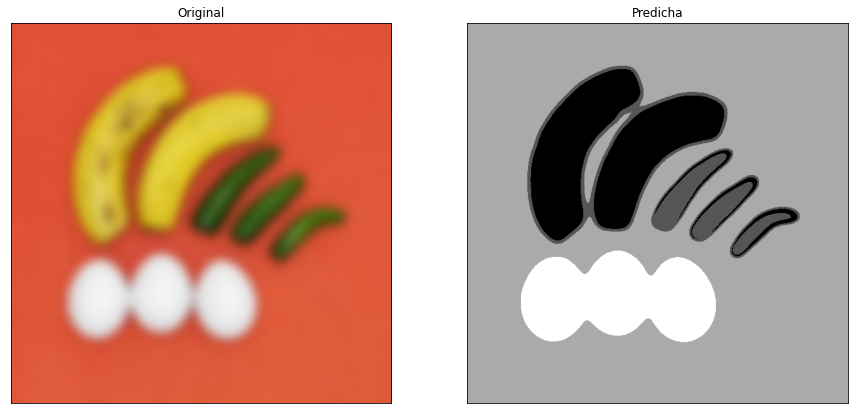

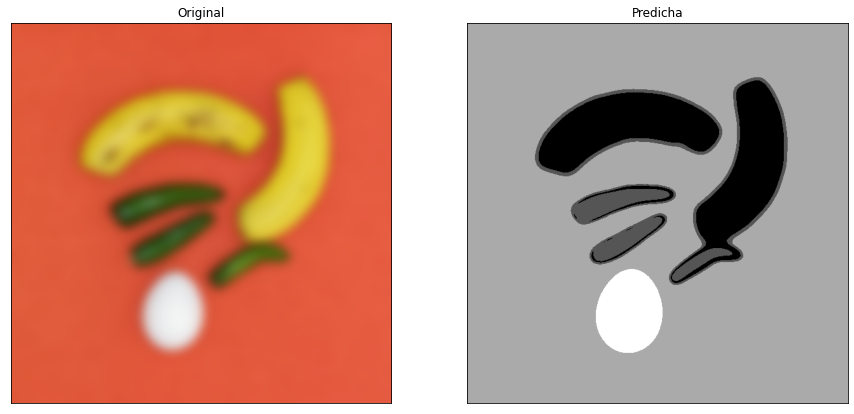

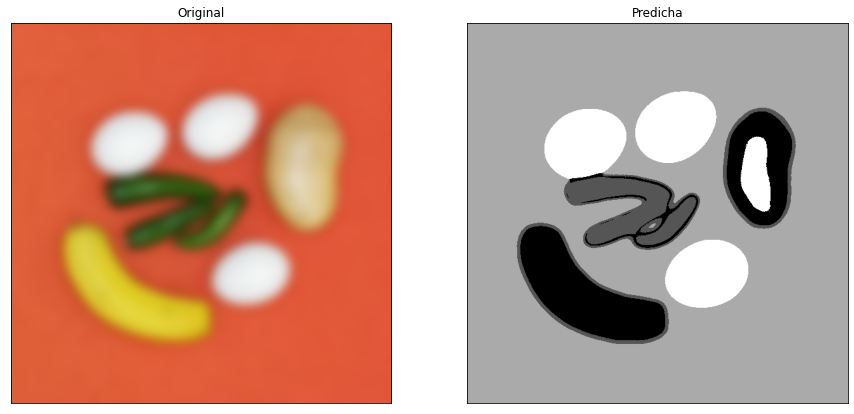

In [ ]:
for resultado,img in zip(list_resultados,list_imagenes):
  plt.figure(figsize=(15,15))
  plt.subplot(121)
  plt.imshow(img)
  plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(122)
  plt.imshow(resultado,cmap='gray')
  plt.title('Predicha')
  plt.xticks([]), plt.yticks([])
  plt.show()

### A mano

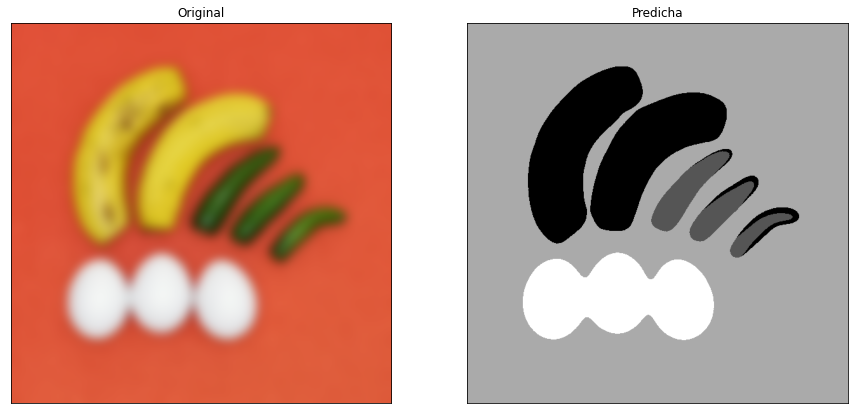

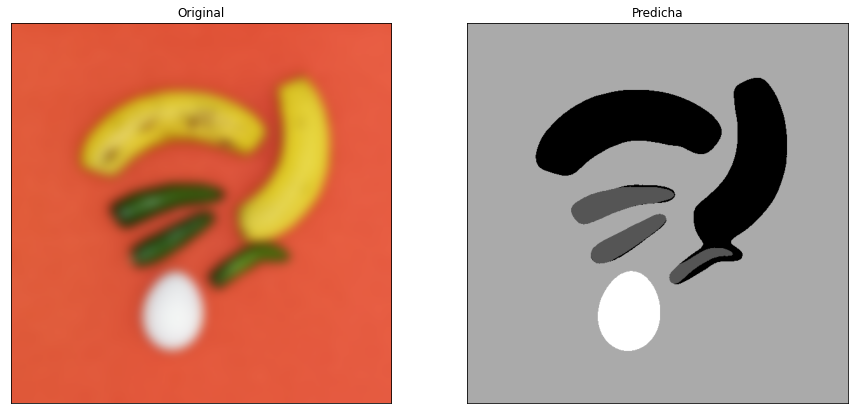

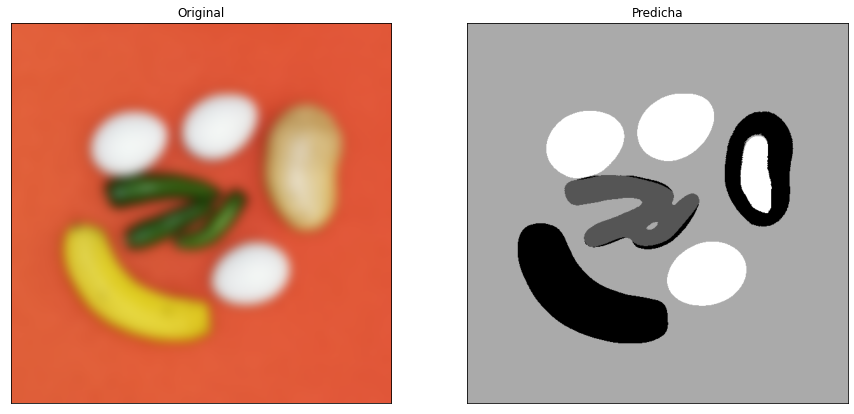

In [ ]:
for resultado,img in zip(list_resultados_mano,list_imagenes):
  plt.figure(figsize=(15,15))
  plt.subplot(121)
  plt.imshow(img)
  plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(122)
  plt.imshow(resultado,cmap='gray')
  plt.title('Predicha')
  plt.xticks([]), plt.yticks([])
  plt.show()

### Comparación

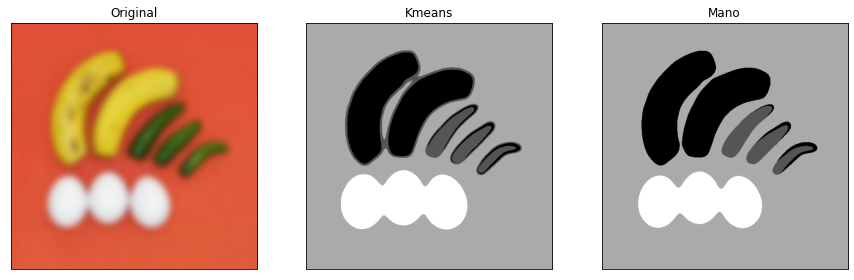

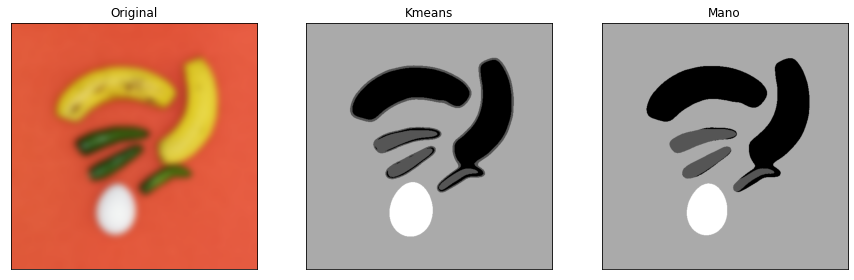

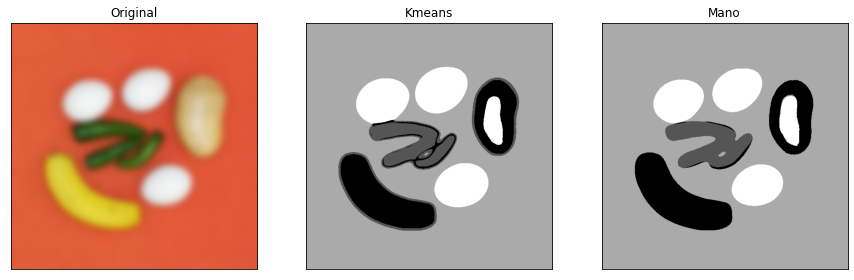

In [ ]:
for resultado_m,resultado_k,img in zip(list_resultados_mano,list_resultados,list_imagenes):
  plt.figure(figsize=(15,15))
  plt.subplot(131)
  plt.imshow(img)
  plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(132)
  plt.imshow(resultado_k,cmap='gray')
  plt.title('Kmeans')
  plt.xticks([]), plt.yticks([])
  plt.subplot(133)
  plt.imshow(resultado_m,cmap='gray')
  plt.title('Mano')
  plt.xticks([]), plt.yticks([])
  plt.show()

## 8 Comparación con scikit-learn
*Utilice la función del clasificador de Bayes de scikit learn. Averigüe como debe de utilizarlo para que pueda introducir sus datos que generó anteriormente, es posible que haya cambios. Compare sus resultados contra los anteriores.*

Grafica la imágen resultante

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

from sklearn.naive_bayes import MultinomialNB

In [ ]:
def cargar_imagenes_clases(dict_url_train):

  dict_imagenes_train = dict()

  for clase, lista_urls in dict_url_train.items():
    lista_imagenes = list()

    for url in lista_urls:
      img = cv2.imread(url)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = aplicar_filtro(img, 51)
      lista_imagenes.append(img)
      
    dict_imagenes_train[clase] = lista_imagenes 

  return dict_imagenes_train

In [ ]:
def arreglo_pixeles(img):

  lista_pixeles = list()

  w,h,p = img.shape 

  for i in range(w):
    for j in range(h):
      lista_pixeles.append(img[i,j,:])

  return np.array(lista_pixeles)

def filtrar_negros(lista_pixeles):

  pixeles_filtrados = list()

  for pixel in lista_pixeles:
    if np.sum(pixel) != 0:
      pixeles_filtrados.append(pixel)

  return np.array(pixeles_filtrados)

In [ ]:
def generar_pixeles_clases(dict_imagenes_train):
  
  pixeles_clases = dict()
  
  for clase, lista_imagenes in dict_imagenes_train.items():
    bandera = True 
    pixeles_imagen = None

    for imagen in lista_imagenes:
      pixeles_planos = arreglo_pixeles(imagen)
      pixeles_filtrados = filtrar_negros(pixeles_planos)
      
      if bandera:
        pixeles_imagen = pixeles_filtrados
        bandera = False
      else:
        pixeles_imagen = np.concatenate((pixeles_imagen, pixeles_filtrados))

    pixeles_clases[clase] = pixeles_imagen
  
  return pixeles_clases

In [ ]:
def etiquetar_pixeles(dict_imagenes_filtrados):

  lista_pixeles_etiquetados = list()
  diccionario_clases = dict()
  i = 0
  for clase, lista_pixeles in dict_imagenes_filtrados.items():
    diccionario_clases[i] = 85*i
    for j in range(lista_pixeles.shape[0]):
      lista_pixeles_etiquetados.append((i,lista_pixeles[j,:]))

    i+=1

  return lista_pixeles_etiquetados, diccionario_clases

In [ ]:
dict_url_train = {
    "platano":[
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento1_platano.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento2_platano.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento3_platano.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento4_platano.jpg"
    ],
    "chile":[
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento1_chile.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento2_chile.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento3_chile.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento4_chile.jpg",
    ],
    "fondo":[
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento1_fondo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento2_fondo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento3_fondo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento4_fondo.jpg",
    ],
    "huevo":[
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento1_huevo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento2_huevo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento3_huevo.jpg",
            "/content/drive/MyDrive/Aux/ComidaMascara/Entrenamiento4_huevo.jpg",
    ]
}

In [ ]:
dict_imagenes_train = cargar_imagenes_clases(dict_url_train)
dict_imagenes_filtrados = generar_pixeles_clases(dict_imagenes_train)
pixeles_etiquetados, diccionario_clases = etiquetar_pixeles(dict_imagenes_filtrados)

In [ ]:
np.random.shuffle(pixeles_etiquetados)

In [ ]:
list_url = [
            "/content/drive/MyDrive/Aux/Comida/Prueba1.jpg",
            "/content/drive/MyDrive/Aux/Comida/Prueba2.jpg",
            "/content/drive/MyDrive/Aux/Comida/Prueba3.jpg"
            ]
list_imagenes = list()
for url in list_url:
  img = cv2.imread(url)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = aplicar_filtro(img, 51)
  list_imagenes.append(img)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

X = np.array([x[1] for x in pixeles_etiquetados])
y = np.array([x[0] for x in pixeles_etiquetados])

clf = MultinomialNB()
clf.fit(X, y)
print(clf.predict(X[2:3])) # [2]

[2]


In [ ]:
imagenes_predecidas = list()
for imagen in list_imagenes:
  w,h,p = imagen.shape
  new_imagen = list()
  for row in range(w):
    new_row = list()
    for column in range(h):
      pixel = np.array([imagen[row,column,:]])
      valor = clf.predict(pixel)
      mapeo = diccionario_clases[valor[0]]
      new_row.append(mapeo)
    new_imagen.append(new_row)
  imagenes_predecidas.append([imagen,new_imagen])

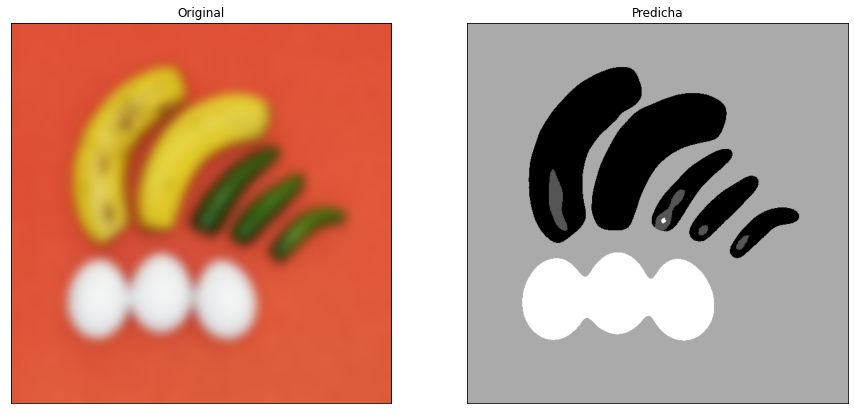

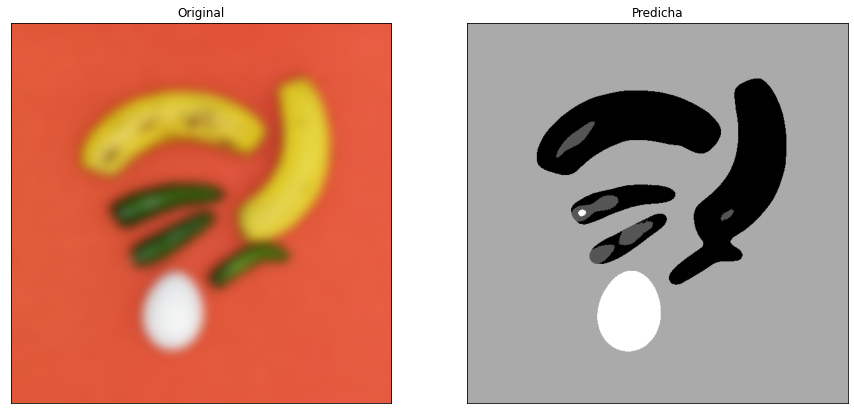

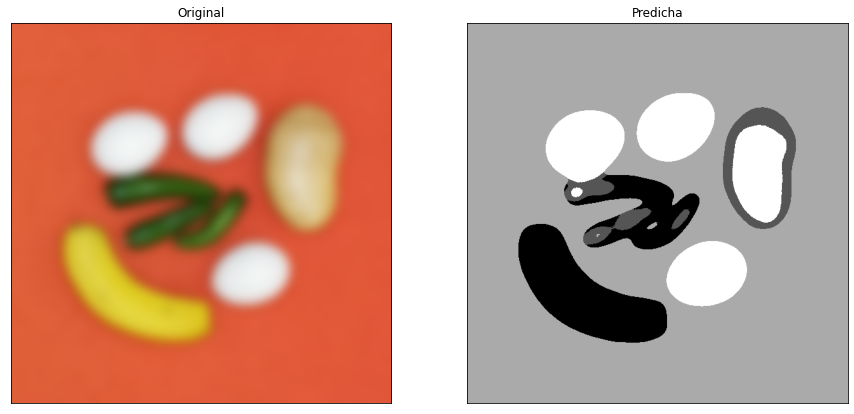

In [ ]:
for par in imagenes_predecidas:
  resultado, img = par[1], par[0]
  plt.figure(figsize=(15,15))
  plt.subplot(121)
  plt.imshow(img)
  plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(122)
  plt.imshow(resultado,cmap='gray')
  plt.title('Predicha')
  plt.xticks([]), plt.yticks([])
  plt.show()

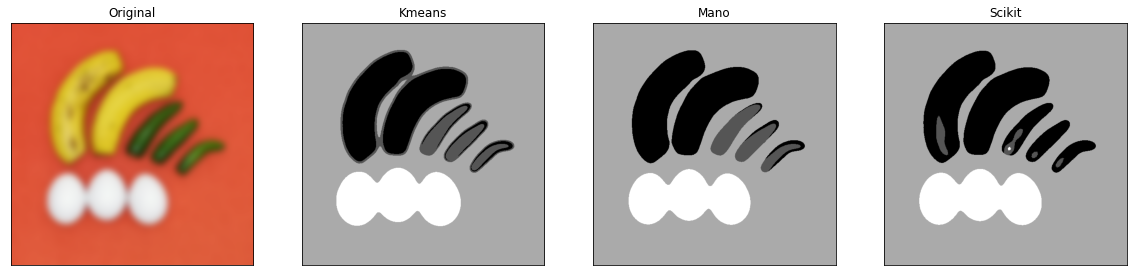

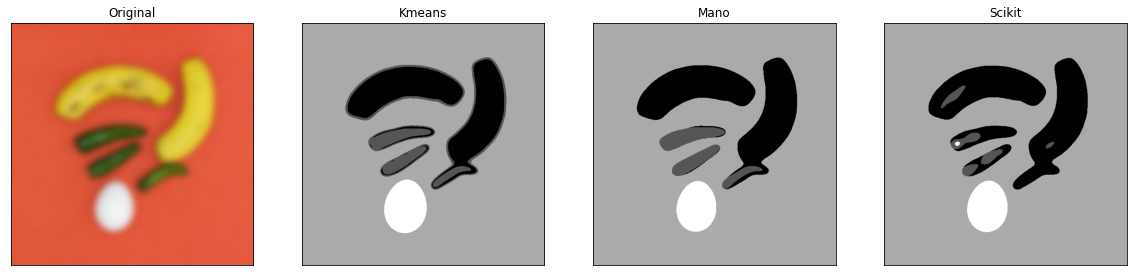

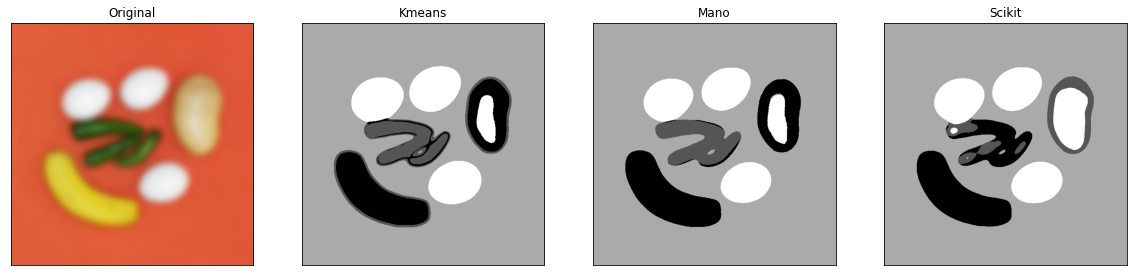

In [ ]:
for resultado_m,resultado_k,img,par in zip(list_resultados_mano,list_resultados,list_imagenes,imagenes_predecidas):
  scik = par[1]
  plt.figure(figsize=(20,20))
  plt.subplot(141)
  plt.imshow(img)
  plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(142)
  plt.imshow(resultado_k,cmap='gray')
  plt.title('Kmeans')
  plt.xticks([]), plt.yticks([])
  plt.subplot(143)
  plt.imshow(resultado_m,cmap='gray')
  plt.title('Mano')
  plt.xticks([]), plt.yticks([])
  plt.subplot(144)
  plt.imshow(scik,cmap='gray')
  plt.title('Scikit')
  plt.xticks([]), plt.yticks([])
  plt.show()